In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import glob

from keras.preprocessing.image import load_img,ImageDataGenerator
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix

In [2]:
print(os.listdir("Data/dogs-vs-cats"))

['sampleSubmission.csv', 'test', 'train']


In [3]:
categories=[]
filenames=os.listdir("Data/dogs-vs-cats/train")
for file in filenames:
    if file.split(".")[0]=='cat':
        categories.append(0)
    else:
        categories.append(1)
    #print(file.split(".")[0])

In [4]:
df=pd.DataFrame({'filename':filenames,'category':categories})

In [5]:
df.shape

(25000, 2)

In [6]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


<AxesSubplot:>

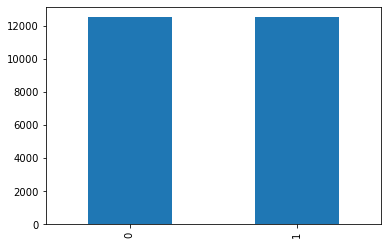

In [7]:
df['category'].value_counts().plot.bar()

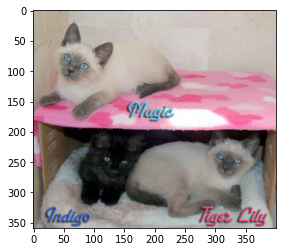

In [8]:
plt.imshow(plt.imread("Data/dogs-vs-cats/train/"+df.sample()['filename'].tolist()[0]))

In [9]:
WIDTH = 180
HEIGHT = 180

In [47]:
model=Sequential(name='Baseline_Model')

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3,3))
model.add(Dropout(0.21))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3,3))
model.add(Dropout(0.23))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3,3))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3,3,padding='same'))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "Baseline_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 176, 176, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)     

In [48]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])

In [49]:
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [90]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

In [51]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [91]:
train_datagenerator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="Data/dogs-vs-cats/train",
                                                     x_col="filename",
                                                     y_col="category",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="raw",
                                                     batch_size=150)

Found 20000 validated image filenames.


In [53]:
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=test,
                                                    directory="Data/dogs-vs-cats/train",
                                                   x_col="filename",
                                                   y_col="category",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="raw",
                                                   batch_size=150)

Found 5000 validated image filenames.


In [54]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [55]:
model.fit(train_datagenerator,
          epochs=50,
          validation_data=test_datagenerator,
          validation_steps=test.shape[0]//150,
          steps_per_epoch=train.shape[0]//150,
          callbacks=callbacks
          )

Epoch 1/50
133/133 [==============================] - 237s 2s/step - loss: 0.6803 - accuracy: 0.5992 - val_loss: 1.0350 - val_accuracy: 0.5042
Epoch 2/50
133/133 [==============================] - 150s 1s/step - loss: 0.5757 - accuracy: 0.7063 - val_loss: 1.1340 - val_accuracy: 0.5036
Epoch 3/50
133/133 [==============================] - 137s 1s/step - loss: 0.5096 - accuracy: 0.7550 - val_loss: 0.6934 - val_accuracy: 0.5630
Epoch 4/50
133/133 [==============================] - 130s 984ms/step - loss: 0.4510 - accuracy: 0.7911 - val_loss: 0.5656 - val_accuracy: 0.7133
Epoch 5/50
133/133 [==============================] - 133s 1s/step - loss: 0.4033 - accuracy: 0.8162 - val_loss: 0.5509 - val_accuracy: 0.7117
Epoch 6/50
133/133 [==============================] - 141s 1s/step - loss: 0.3612 - accuracy: 0.8395 - val_loss: 0.6585 - val_accuracy: 0.6610

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
133/133 [==============================] - 142s

In [56]:
model.save('model.h5')

In [57]:
model.summary()

Model: "Baseline_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 176, 176, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)     

In [58]:
test_filenames = os.listdir("Data/dogs-vs-cats/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [59]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Data/dogs-vs-cats/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(WIDTH,HEIGHT),
    batch_size=150,
    shuffle=False
)

Found 12500 validated image filenames.


In [61]:
predict = model.predict(test_generator, steps=np.ceil(test_df.shape[0]/150))

In [77]:
predict = [1 if i>0.5 else 0 for i in predict]

In [80]:
test_df['category']=predict

In [81]:
test_df

,filename,category
0,1.jpg,1
1,10.jpg,0
2,100.jpg,0
3,1000.jpg,1
4,10000.jpg,0
...,...,...
12495,9995.jpg,1
12496,9996.jpg,1
12497,9997.jpg,1
12498,9998.jpg,0


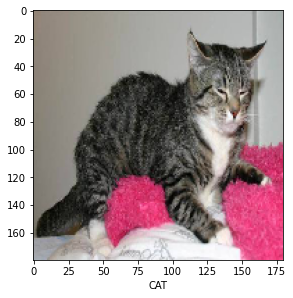

In [345]:
sample_test=test_df.sample()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    lbl = "DOG" if category==1 else "CAT"
    img = load_img("Data/dogs-vs-cats/test/"+filename, target_size=(180,180))
    plt.subplot(6, 3, 6)
    plt.imshow(img)
    plt.xlabel(lbl)
plt.tight_layout()
plt.show()

In [185]:
dic = dict(zip([int(i.split('.')[0]) for i in test_df['filename'].tolist()],test_df['category'].tolist()))

In [186]:
dic

{1: 1,
 10: 0,
 100: 0,
 1000: 1,
 10000: 0,
 10001: 0,
 10002: 0,
 10003: 1,
 10004: 1,
 10005: 0,
 10006: 0,
 10007: 0,
 10008: 0,
 10009: 0,
 1001: 0,
 10010: 1,
 10011: 1,
 10012: 0,
 10013: 0,
 10014: 0,
 10015: 1,
 10016: 1,
 10017: 0,
 10018: 0,
 10019: 0,
 1002: 1,
 10020: 0,
 10021: 0,
 10022: 1,
 10023: 1,
 10024: 1,
 10025: 1,
 10026: 1,
 10027: 1,
 10028: 0,
 10029: 1,
 1003: 1,
 10030: 1,
 10031: 0,
 10032: 0,
 10033: 0,
 10034: 1,
 10035: 1,
 10036: 1,
 10037: 0,
 10038: 1,
 10039: 1,
 1004: 1,
 10040: 0,
 10041: 1,
 10042: 1,
 10043: 1,
 10044: 0,
 10045: 1,
 10046: 1,
 10047: 1,
 10048: 1,
 10049: 0,
 1005: 0,
 10050: 0,
 10051: 1,
 10052: 0,
 10053: 1,
 10054: 0,
 10055: 0,
 10056: 1,
 10057: 0,
 10058: 1,
 10059: 1,
 1006: 1,
 10060: 1,
 10061: 1,
 10062: 0,
 10063: 1,
 10064: 1,
 10065: 1,
 10066: 0,
 10067: 0,
 10068: 0,
 10069: 0,
 1007: 1,
 10070: 0,
 10071: 0,
 10072: 0,
 10073: 1,
 10074: 0,
 10075: 0,
 10076: 0,
 10077: 0,
 10078: 1,
 10079: 0,
 1008: 0,
 10080

In [187]:
id=[]
label=[]
for i in sorted(dic):
    id.append(i)
    label.append(dic[i])

In [188]:
label

[1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,


In [190]:
dic={}
for i in range(len(id)):
    dic[id[i]]=label[i]

In [325]:
df=pd.DataFrame()
df['id']=dic.keys()
df['label']=dic.values()

In [326]:
df

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
12495,12496,0
12496,12497,0
12497,12498,1
12498,12499,1


In [327]:
df.to_csv("submission.csv",index=False)